<a href="https://colab.research.google.com/github/epi2me-labs/testbooks/blob/master/enrichment_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Cas9 Enrichment Tutorial</h1>

This tutorial is intended as a introduction into the analysis of a Cas9 enrichment experiment with nanopore sequencing. The tutorial will step through a discuss the steps of the workflow starting from raw sequencing data. We will learn how to:

* Align read data to a human reference sequence
* Show the sequencing depth for target regions
* Analyse the proportion of off-target reads

The tutorial makes use of some common bioinformatics including:

* `mini_align` - a simple interface to the [`minimap2`](https://github.com/lh3/minimap2) alignment program.
* [`pyranges`](https://github.com/biocore-ntnu/pyranges) - GenomicRanges and genomic Rle-objects for Python.

Computational requirements for this tutorial include:

- Computer running the **Epi2Me Labs** notebook Server
- At least 8 Gb RAM


## Introduction

The tutorial requires a FASTQ format sequence file and a BED file of target coordinates as input, along with pointers to download locations for the reference genome to be used.

The tutorial aids with the quantification of the non-target depletion and provides information on mapping characteristics that highlight the protocol performance. The figures plotted include depth-of-coverage over the target regions and strand bias over these regions. The location and peaks of coverage and local biases in strandedness may be used to assess the performance of guide-RNA sequences and may highlight guide RNAs that are not performing. A review of likely off-target regions over-represented within the sequence collection may inform of strategies to refine guide-RNA design.

**Before stepping through the workflow be sure to connect this notebook to your local Epi2Me Labs server in the top right of the screen.** [Further details](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#connecting)


## Data preparation

To start analysing our experiment we must first "read in" the data. For this example we will first download three files:

1. A `.fast5` file containing our sequencing data
2. The human reference genome
3. A `.bed` file describing the target regions of the genome


### Sample Data

To use this tutorial with sample data we can download the files using the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

To get started we will download a sample sequencing dataset, click on the cell below and press the "Play" symbol to the left:

In [0]:
# download the data
!wget https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/cas9_tutorial/sample_cas9.tar.gz
# the data is in a compressed archive so let's decompress it
! tar -xzvf sample_cas9.tar.gz

The data downloaded is laid-out in the form as written by MinKNOW on a sequencing device, only reads passing the quality score filter applied by MinKNOW has been included (again click the cell and press play):

In [0]:
!tree sample_cas9

For our analysis we will also need the human genome reference, which we can download from NCBI:

In [0]:
!mkdir -p sample_cas9_outputs
!wget -O "sample_cas9_outputs/grch38.fasta.gz" http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz
# decompress and recompress with bgzip
!gunzip "sample_cas9_outputs/grch38.fasta.gz"
!run bgzip sample_cas9_outputs/grch38.fasta

Finally we will need a `BED` file describing the target regions of the genome.

In [0]:
!wget -O sample_cas9_outputs/htt.bed https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/cas9_tutorial/htt.bed

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `data_folder` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

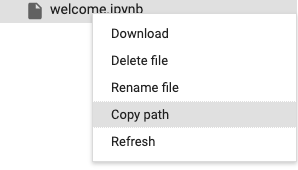

When pasting the path in the code cell you will have to remove the preceding `/` character.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after executing the cell below.**

In [487]:
#@markdown Enter the paths to you input files and output folder here:

# set variables for our inputs
data_folder='sample_cas9/fastq_pass'  #@param {type: "string"}
output_folder='sample_cas9_outputs'  #@param {type: "string"}
reference_genome='sample_cas9_outputs/grch38.fasta.gz' #@param {type: "string"}
bed_file='sample_cas9_outputs/targets.bed' #@param {type: "string"}

fastq = output_folder + '/all_data.fastq'

# run a command to concatenate all the files together
!echo "Making output folder"
!test -f "$reference_genome" || "WARNING: Reference file does not exist"
!mkdir -p "$output_folder"
!concatenate_fastqs "$data_folder" "$fastq"

region_bed = pd.read_csv(
    bed_file, sep='\t', header=None,
    # https://genome.ucsc.edu/FAQ/FAQformat.html#format1
    names=[
        'chrom', 'start', 'end',  #required
        'tname', 'score', 'strand', 'thickStart', 'thickEnd',
        'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

region_bed['region'] = [
    '{}:{}-{}'.format(x['chrom'], x.start, x.end)
    for _, x in region_bed.iterrows()]


Making output folder
Found files, concatenating
Written data to sample_cas9_outputs/all_data.fastq


## Alignment of reads

Our first task in analysing our data is to align the sequence reads to the reference sequence. We do this with the `mini_align` program from the [`pomoxis`](https://github.com/nanoporetech/pomoxis) package. This is preinstalled in the **Epi2Me Labs** notebook server. Note that this command may take a while to run depending on the number of reads in your datasets. With the sample data (8000 reads) and using 4 compute threads (`-t 4` in the code), the alignments will take around 5 minutes.


In [189]:
!run mini_align \
    -r "$reference_genome" -i "$output_folder/all_data.fastq" \
    -p "$output_folder/alignments" \
    -t 3 -m

Found minimap files.
[M::main::223.540*0.79] loaded/built the index for 195 target sequence(s)
[M::mm_mapopt_update::270.033*0.83] mid_occ = 694
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 195
[M::mm_idx_stat::274.290*0.83] distinct minimizers: 100167746 (38.80% are singletons); average occurrences: 5.519; average spacing: 5.607
[M::worker_pipeline::408.163*1.47] mapped 7853 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -x map-ont --MD -t 3 -a sample_cas9_outputs/grch38.fasta.gz.mmi sample_cas9_outputs/all_data.fastq
[M::main] Real time: 454.291 sec; CPU: 646.714 sec; Peak RSS: 8.483 GB
[bam_sort_core] merging from 0 files and 3 in-memory blocks...


While we are here we will calculate also a table summarising the alignment data, again using a program from `pomoxis`:

In [191]:
!run stats_from_bam "$output_folder/alignments.bam" \
    > "$output_folder/alignments.stats"

Mapped/Unmapped/Short/Masked: 7827/0/0/0


The summary file gives useful information on the alignment of each read to the reference sequence, including: chromosome, start and end coordinates, and the accuracy of the read with respect to the reference. We can plot a histogram of the latter quantity:

In [447]:
#@markdown ***Accuracy distribution code*** (*click to show*)

#load python libraries
from bokeh.plotting import figure
from bokeh.models import Range1d
import bokeh.io as bkio
import numpy as np
import pandas as pd
from scipy import stats as sp_stats

aln_summary = pd.read_csv(
    '{}/alignments.stats'.format(output_folder),
    delimiter='\t')


def kernel_density_estimate(x, step=0.2):
    """Kernel density to approximate distribution

    :param x: data of which to find mode.
    :param step: discretization of KDE PDF.
    """
    # estimate bandwidth of kde, R's nrd0 rule-of-thumb
    hi = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    lo = min(hi, iqr/1.34)
    if not ((lo == hi) or (lo == abs(x[0])) or (lo == 1)):
        lo = 1
    bw = 0.9 * lo *len(x)**-0.2

    # create a KDE
    x_grid = np.arange(min(x), max(x), step)
    kernel = sp_stats.gaussian_kde(x, bw_method=bw)
    pdf = kernel(x_grid)
    return x_grid, pdf

x_grid, pdf = kernel_density_estimate(aln_summary.acc)
mode_acc = x_grid[np.argmax(pdf)]
mean_acc = aln_summary.acc.mean()

# create a figure
p = figure(
    title='Read accuracy distribution',
    output_backend="webgl",
    height=300, width=600)

p.line(x=x_grid, y=pdf, line_width=1.5)


# plot a vertical line for mean and N50 read length
line_types = (('Mean', mean_acc), ('Mode', mode_acc))
for name, val in line_types:
    p.line(
        x=[val, val], y=[0, 0.8*max(pdf)],
        line_width=1.5, color='black')
    p.text(x=[val], y=[0.8*max(pdf)],
        text=['{}: {:.1f}'.format(name, val)],
        angle=1, alpha=0.4)

# limit the display range
p.x_range = Range1d(start=80, end=100, bounds=(0, None))
p.y_range = Range1d(start=0, end=1.2*max(pdf), bounds=(0, None))
# add axis labels
p.xaxis.axis_label = 'Read Accuracy'
p.yaxis.axis_label = 'Number of reads'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

The statistics file has many other columns which are interesting to explore:

In [0]:
aln_summary.info()

## On Target Depth

In this section we will examine the 

For this purpose and throughout the rest of this tutorial we will use the [`Pyranges`](https://github.com/biocore-ntnu/pyranges) library.

# Simple Overlaps

As a first look at the data lets tabulate the number of reads overlapping each target. 

In [729]:
import pyranges as pr

targets = region_bed[['chrom','start','end','tname']].rename(
    columns={'chrom':'Chromosome','start':'Start','end':'End'}
)
target_names = targets['tname'].to_list()
targets = pr.PyRanges(targets)

reads = aln_summary.rename(
    columns = {'ref':'Chromosome','rstart':'Start','rend':'End'}
)
reads = pr.PyRanges(reads)
ovl_summary = targets.count_overlaps(reads)
ovl_summary.df

,Chromosome,Start,End,tname,NumberOverlaps
0,chr1,155130000,155250000,MUC1,28
1,chr4,3024876,3124934,HTT,87
2,chr6,170511908,170612015,SCA17,76
3,chr9,27523486,27623547,C9orf72,39
4,chr11,2111515,2212203,INS,55
5,chr12,111548951,111649019,SCA2,233
6,chr14,92021011,92121034,SCA3,95
7,chr19,13157859,13257897,SCA6,63
8,chr22,45745355,45845424,SCA10,125
9,chrX,147862050,147962110,FMR1,71


The table above summaries the number of times a read overlaps one of the targets. We can also think about the inverse problem, how many times the targets intersect the reads; this allows us to calculate approximately numbers of on-target and off-target bases:

In [564]:
# get on/off target reads
ovl = reads.count_overlaps(targets)
on_target = ovl[ovl.NumberOverlaps > 0]
off_target = ovl[ovl.NumberOverlaps == 0]
def summarize(df):
    count = len(df)
    bases = sum(df.End) - sum(df.Start)
    ave_len = int(df.read_length.mean())
    return count, bases // 1000, ave_len
on_stats = summarize(on_target)
off_stats = summarize(off_target)

info = pd.DataFrame([
        on_stats, off_stats],
    columns=['Reads', 'Bases / k', 'Mean Read Length'],
    index=['On target', 'Off target'],
    ).transpose()
info['Total'] = info['On target'] + info['Off target']
display(info)

,On target,Off target,Total
Reads,872,6955,7827
Bases / k,4884,64153,69037
Mean Read Length,5563,9345,14908


### Genome tiles

In order to quickly calculate more detailed statistics (and create informative plots), we will use a tiling technique. We will split the reference genome into uniformly sized tiles; for each reference tile we can calculate the overlapping reads. For the reference we construct the tiles using the `pysam` library to read the `reference_genome` file:

In [0]:
import pysam
tile_size = 100

ref = pysam.FastaFile(reference_genome)
ref_tiles = pr.PyRanges(
    chromosomes=ref.references,
    starts=[0] * ref.nreferences,
    ends=ref.lengths
).tile(tile_size=tile_size)

We will also define a small helper function to annotate genomic regions with additional information:

In [0]:
#@markdown **set_column** function for annotating regions
def set_column(pyr, chrom, loc, column, value):
    """Sets a column of a `PyRange` to a specified value.
    
    :param pyr: a `PyRange`.
    :param chrom: a chromosome.
    :param loc: a `Slice` (start, stop).
    :param column: column name.
    :param value: value to set the column.
    """
    from pyranges.subset import find_overlaps
    if pyr.stranded:
        raise NotImplementedError("`set_column` does not handled strandedness")

    dfs = {chrom: pyr.dfs[chrom]}
    max_end = list(dfs.values())[0].End.max()
    
    start = loc.start or 0
    stop = loc.stop or max(max_end, start)
    for k, df in dfs.items():
        idx = find_overlaps(df, start, stop)
        df.loc[idx, column] = value

To proceed we will first use the function defined above to annotate our genome tiles and our reads with their target:

In [0]:
# Label reference genome tiles, and the reads
ref_tiles.tname = 'Off Target'
reads.tname = 'Off Target'
for chrom, df in targets:
    for _, t in df.iterrows():
        print("Labelling {}".format(t.tname))
        set_column(
            ref_tiles, t.Chromosome, slice(t.Start, t.End),
            'tname', t.tname)
        set_column(
            reads, t.Chromosome, slice(t.Start, t.End),
            'tname', t.tname)
# count overlaps of read tiles to ref_tiles (similar to before)
hits = ref_tiles.count_overlaps(reads)

Having prepared these tables we can now query them in various ways. Let's summarise the information we have for each target:

In [771]:
def target_info(target_name, targets, hits, read_tiles, reads):
    info = targets[targets.tname == target].df
    # Find intersecting hits
    t_hits = hits.intersect(pr.PyRanges(info)).df
    t_reads = reads.df[reads.df['tname'] == target]

    info['tsize'] = info.End - info.Start
    info['nreads'] = t_reads['name'].unique().size
    # use the tiles to calculate bases on target as parts of reads
    # may not overlap
    info['kbases'] = tile_size * t_hits['NumberOverlaps'].sum() / 1000
    info['mean_coverage'] = t_hits['NumberOverlaps'].mean()
    info['mean_read_length'] = int(t_reads['read_length'].mean())
    info['mean_accuracy'] = t_reads['acc'].mean()
    
    fwd, rev = (len(t_reads[t_reads['direction'] == x]) for x in ('+', '-'))
    info['strand_bias'] = (fwd - rev) / (fwd + rev)
    return info

results = list()
for target in target_names:
    results.append(target_info(
        target, targets, hits, read_tiles, reads
    ))
results = pd.concat(results).rename(columns={
    'Chromosome':'chrom', 'Start':'start', 'End':'end'})
pd.options.display.float_format = '{:,.2f}'.format
display(results)

KeyError: ignored

Using the tiling statistics we can make coverage plots for any region. 

In [770]:
#@markdown **Coverage plot code** (*click to show*)
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_target(target=default_target):
    info = targets[targets.tname == target].df
    display(info)
    t = hits.intersect(pr.PyRanges(info)).df
    fig, ax = plt.subplots()
    ax.ticklabel_format(style='plain')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(t.Start, t.NumberOverlaps)
    plt.xticks(rotation=30)
    plt.xlabel('position')
    plt.ylabel('coverage')
    plt.show()

default_target = target_names[0]
widgets.interactive(
    plot_target, target=target_names)


interactive(children=(Dropdown(description='target', options=('MUC1', 'HTT', 'SCA17', 'C9orf72', 'INS', 'SCA2'…

## Examining Off Target Effects

## Summary

This tutorial has stepped through basic processing of a Cas9 enrichment experiment. We have examined the coverage of a single target region and the rate of off target effects.

The code will run within **Google Colab** when connected to a local **Epi2Me Labs** notebook server.

[Back to Epi2Me Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
